In [1]:
import os

# Data analytics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data modeling
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    explained_variance_score,
    r2_score,
    mean_squared_error)

# Geospatial packages
import h3
import geopandas as gpd
from shapely import Point, Polygon
from pysal.explore import esda
from libpysal.weights import Queen, lag_spatial
from splot.esda import moran_scatterplot, lisa_cluster

C:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\Miguel\Documents\Github\

# Modelo de regresón lineal agregado por año y elemento H3

El modelo de este notebook utiliza técnicas convencionales de aprendizaje automático para un regresión lineal.

El tratamiento del componente geoespacial, es decir, los elementos de malla hexagonales de H3, se incorpora al modelo utilizando _One Hot Encoding_ de los elementos de la malla.

Para las primeras iteraciones, se utilizará un modelo sin componente temporal de la forma:

$$y = \beta_0 + \beta_1\cdot\hat T_{t,i} + \beta_2\cdot\hat P_{t,i} + \phi_{[H]}$$

En donde:
* $\hat T_{t,i}$: Temperatura promedio del $i$-ésimo elemento hexagonal al tiempo $t$
* $\hat P_{t,i}$: Precipitación promedio del $i$-ésimo elemento hexagonal al tiempo $t$
* $\phi_{[H]}$: Efecto del elemento hexagonal $H$ como variable indicadora

Dada la estructura de datos, se pueden utilizar los datos del **2010 al 2017** como conjunto de **entrenamiento**, los datos del **2018 al 2019** como conjunto de **validación**, para finalmente hacer predicciones sobre el **2020** como conjunto de **prueba**.

## Carga de datos

In [2]:
# Ruta a archivos de datos
DATA_PATH = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    'hist-maize-panel-rcp2p6.csv')

H3_CATALOGUE = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    '01_h3_cells_catalogue.csv')

# Carga de datos
data = pd.read_csv(DATA_PATH)
cat_h3 = pd.read_csv(H3_CATALOGUE)
h3_res = 'hex_2'

# Unir resolución de malla a datos
data = (
    data
    .join(
        other=cat_h3[['id',h3_res]]
        ,on='id'
        ,how='left'
        ,rsuffix='__ignore')
    .drop(columns=['id','lon','lat','mean.precip.2','mean.temp.2','id__ignore'])
    .query("(year >= 2010) & (year <= 2020)")
    .groupby(by=['year', h3_res])
    .mean()
    .reset_index())

data.columns = [col.replace('.','_') for col in data.columns]

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677 entries, 0 to 17676
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         17677 non-null  int64  
 1   hex_2        17677 non-null  object 
 2   mean_precip  17677 non-null  float64
 3   mean_temp    17677 non-null  float64
 4   mean_yield   17677 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 690.6+ KB


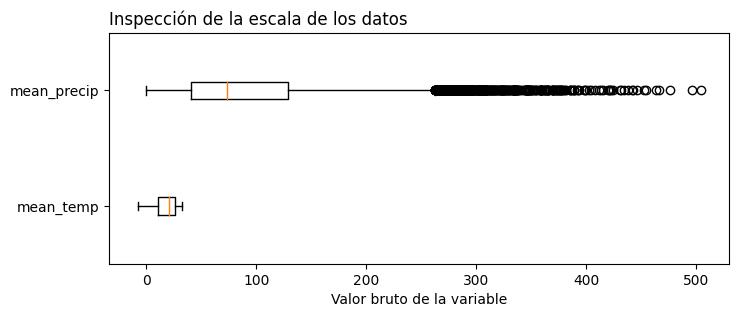

In [3]:
# Variables de visualización
vis_feats = ['mean_temp','mean_precip']

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.boxplot(
    x=data.filter(items=vis_feats),
    vert=False)

# Anotaciones y estilo
ax.set_title('Inspección de la escala de los datos', loc='left')
ax.set_yticks(ticks=[1,2], labels=vis_feats)
ax.set_xlabel('Valor bruto de la variable')

plt.show()

Dada la diferencia en la escala de los datos, se aplicará algún tipo de estandarización a la variables de entrada al modelo

## Partición en Train y Test

In [4]:
# Definición de variable objetivo
target = 'mean_yield'

# Partición de conjuntos de datos
# Estructura de predictores
# 0: h3_res
# 1: mean_precip
# 2: mean_temp

x_train = (
    data
    .query("year <= 2017")
    .drop(columns=['year',target]))
    #.to_numpy())
y_train = (
    data
    .query("year <= 2017")
    .filter(items=[target]))
    #.to_numpy())

x_val = (
    data
    .query("year in [2018, 2019]")
    .drop(columns=['year',target]))
    #.to_numpy())
y_val = (
    data
    .query("year in [2018, 2019]")
    .filter(items=[target]))
    #.to_numpy())

x_test = (
    data
    .query("year == 2020")
    .drop(columns=['year',target]))
    #.to_numpy())
y_test = (
    data
    .query("year == 2020")
    .filter(items=[target]))
    #.to_numpy())

print(
    f"""Datasets dimensions:
    x_train: {x_train.shape}
    y_train: {y_train.shape}
    x_val: {x_val.shape}
    y_val: {y_val.shape}
    x_test: {x_test.shape}
    y_test: {y_test.shape}""")

Datasets dimensions:
    x_train: (12856, 3)
    y_train: (12856, 1)
    x_val: (3214, 3)
    y_val: (3214, 1)
    x_test: (1607, 3)
    y_test: (1607, 1)


## Ingeniería de características

Primero se construye la cadena de transformaciones de los datos

In [5]:
# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),])

# One Hot Encoder
ohe_encoder = OneHotEncoder(
    drop='first',
    handle_unknown='error',
    sparse_output=False)

# Full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, x_train.select_dtypes(include=[int, float]).columns),
    ('cat', ohe_encoder, x_train.select_dtypes(include=[object]).columns)])

In [6]:
x_train = full_pipeline.fit_transform(x_train)
x_val = full_pipeline.fit_transform(x_val)
x_test = full_pipeline.fit_transform(x_test)

# Inspeccionar dimensiones
x_train.shape, x_val.shape, x_test.shape

((12856, 1608), (3214, 1608), (1607, 1608))

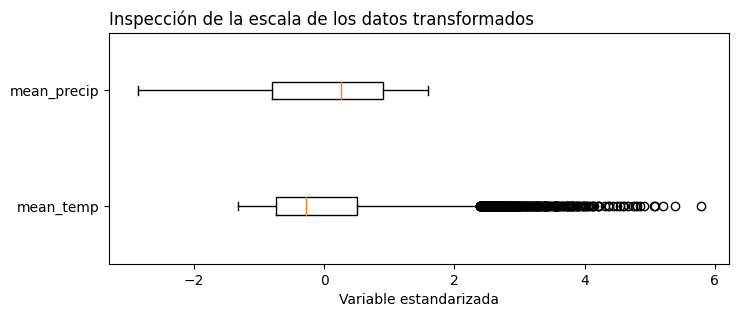

In [7]:
# Variables de visualización
vis_feats = ['mean_temp','mean_precip']

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.boxplot(
    x=x_train[:,0:2],
    vert=False)

# Anotaciones y estilo
ax.set_title('Inspección de la escala de los datos transformados', loc='left')
ax.set_yticks(ticks=[1,2], labels=vis_feats)
ax.set_xlabel('Variable estandarizada')

plt.show()

## Modelo de regresión lineal

Entrenamiento de modelo

Tiempo de procesamiento: [`6min 48s`, `7min 38s`, `7min 34s`, `6min 58s`]

In [8]:
%%time
# Iniciar instancia de modelo
ols = LinearRegression(
    fit_intercept=True,
    n_jobs=-1)

# Entrenamiento
ols.fit(X=x_train, y=y_train)

CPU times: total: 2.59 s
Wall time: 4.32 s


LinearRegression(n_jobs=-1)

Coeficiente de determinación para datos de entrenamiento

$R^2 = 0.928973$

In [9]:
ols.score(X=x_train, y=y_train)

0.940934845681703

Otras métricas de desempeño dentro del conjunto de entramiento

In [10]:
y_pred = ols.predict(X=x_train)

In [11]:
var_score_train = explained_variance_score(y_true=y_train, y_pred=y_pred)
r2_train = r2_score(y_true=y_train, y_pred=y_pred)
rmse_train = mean_squared_error(y_true=y_train, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_train:.2f} %
    coef. determinación: {r2_train:.6f}
    RMSE: {np.sqrt(rmse_train):.6f}""")

Métricas en train:
    varianza explicada: 94.09 %
    coef. determinación: 0.940935
    RMSE: 0.871427


## Desempeño en conjunto de Validación

In [12]:
y_pred = ols.predict(X=x_val)

In [13]:
var_score_val = explained_variance_score(y_true=y_val, y_pred=y_pred)
r2_val = r2_score(y_true=y_val, y_pred=y_pred)
rmse_val = mean_squared_error(y_true=y_val, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_val:.2f} %
    coef. determinación: {r2_val:.6f}
    RMSE: {np.sqrt(rmse_val):.6f}""")

Métricas en train:
    varianza explicada: 91.36 %
    coef. determinación: 0.910626
    RMSE: 1.017129


## Normalidad geoespacial de residuales

### Datos expandidos

In [14]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '01_ols_regression.csv')

In [15]:
residual_test = (
    data
    .query("year in [2018, 2019]")
    .assign(
        mean_yield_pred = y_pred,
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [16]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)
residual_test.head()

,year,hex_2,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals
0,2018,820837fffffffff,141.437310,8.117091,5.252216,5.241778,-0.010438
1,2018,820887fffffffff,49.480511,8.117420,4.951842,4.328228,-0.623615
2,2018,82088ffffffffff,64.324353,7.279252,4.375731,4.206291,-0.169439
3,2018,820897fffffffff,64.624282,9.466836,6.082495,4.714628,-1.367867
4,2018,82089ffffffffff,62.615391,8.282647,3.806198,3.639036,-0.167162


In [17]:
def get_h3_polygon(row:str):
    points = h3.cell_to_boundary(
        h=row
        ,geo_json=True)

    return Polygon(points)

In [18]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test[h3_res].apply(func=get_h3_polygon))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,year,hex_2,mean_precip,mean_temp,mean_yield,mean_yield_pred,residuals,geometry
0,2018,820837fffffffff,141.437310,8.117091,5.252216,5.241778,-0.010438,"POLYGON ((7.64620 64.66507, 4.69492 64.57086, ..."
1,2018,820887fffffffff,49.480511,8.117420,4.951842,4.328228,-0.623615,"POLYGON ((16.21329 61.10409, 15.27742 59.85120..."
2,2018,82088ffffffffff,64.324353,7.279252,4.375731,4.206291,-0.169439,"POLYGON ((19.28100 61.41675, 21.28918 60.46251..."
3,2018,820897fffffffff,64.624282,9.466836,6.082495,4.714628,-1.367867,"POLYGON ((17.28620 58.92634, 16.36093 57.62270..."
4,2018,82089ffffffffff,62.615391,8.282647,3.806198,3.639036,-0.167162,"POLYGON ((20.23591 59.22587, 22.14428 58.20922..."


### Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [19]:
# Matriz de pesos espaciales
W = Queen.from_dataframe(
    df=residual_test,
    geom_col='geometry',
    silence_warnings=True)
# W = KNN.from_dataframe(
#     df=residual_test,
#     k=10,
#     geom_col='geometry',)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [20]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

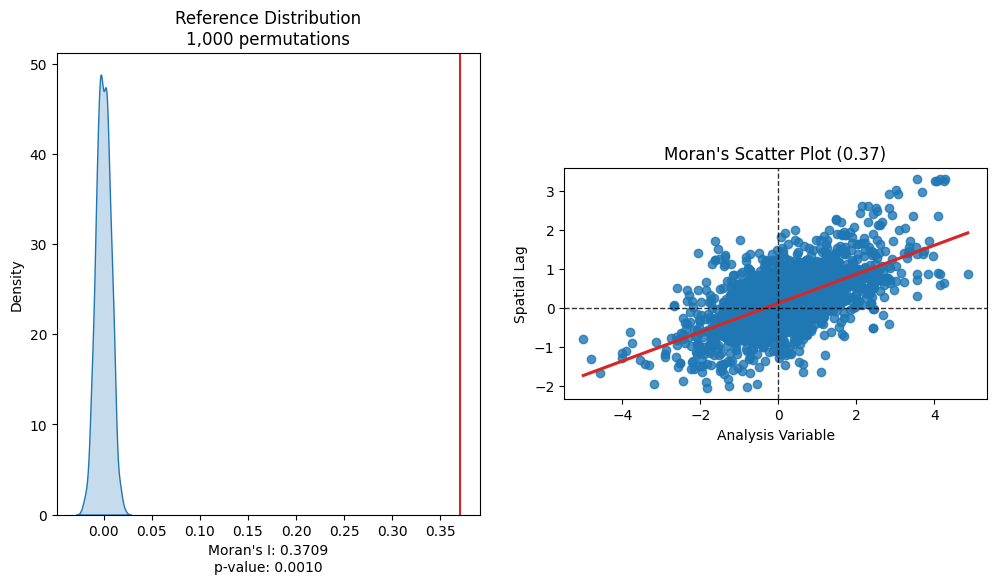

In [21]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

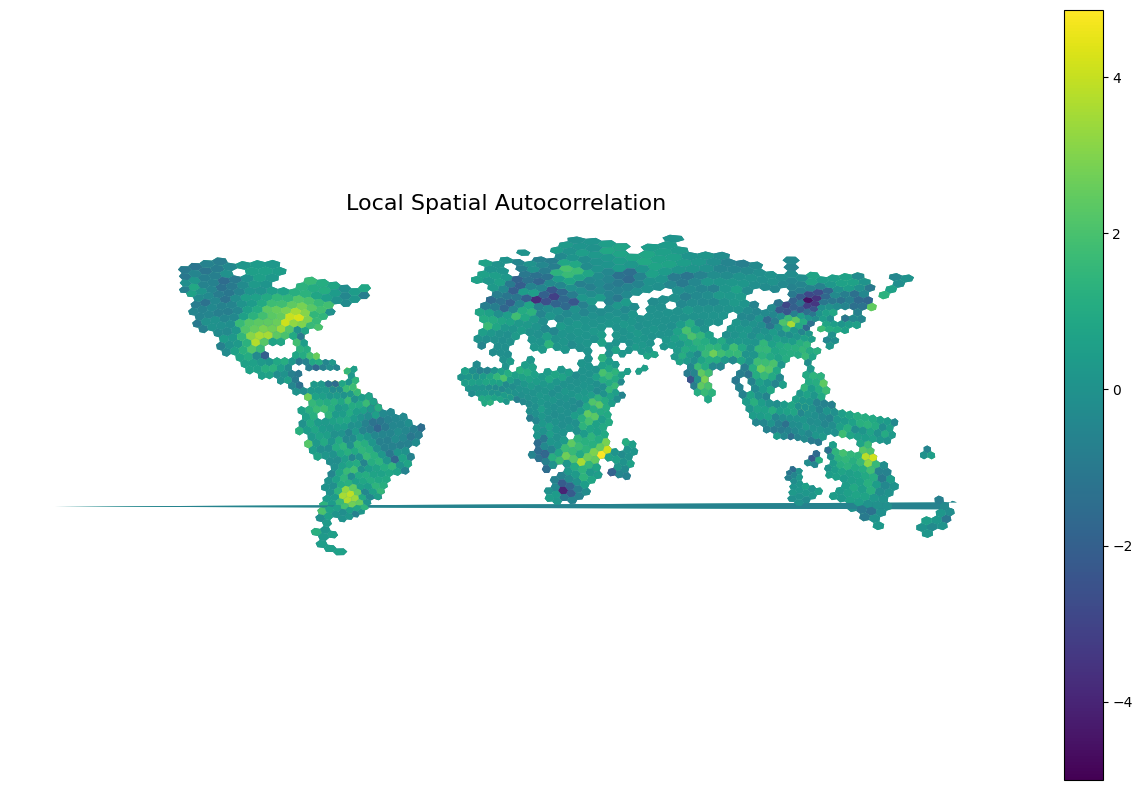

In [22]:
# Figure specs
fig, ax = plt.subplots(figsize=(16,10))

# Visualization elements
residual_test.plot(
    column='residuals'
    ,legend=True
    ,ax=ax)

# Styling
ax.set_title(
    label='Local Spatial Autocorrelation'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()

# Modelo con regularización Elastic Net

Primero se define una instancia de _GridSearch_ para la optimización de modelo Elastic Net

In [23]:
%%time

# Espacio parametral
grid = {
    'alpha': np.logspace(start=-2, stop=2, num=25),
    'l1_ratio': np.arange(start=0, stop=1.1, step=0.1)}

# Instancia de modelo a optimizar
elastic_net = ElasticNet(
    fit_intercept=True,)

# Iniciar objeto de optimización
gsearch = GridSearchCV(
    estimator=elastic_net,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=4,
    verbose=1,
    return_train_score=True)

# Entrenamiento de modelo
gsearch = gsearch.fit(X=x_train, y=y_train)

# Almacenar resultados
results = gsearch.cv_results_

Fitting 4 folds for each of 275 candidates, totalling 1100 fits
CPU times: total: 1min 35s
Wall time: 29min 43s


C:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.605e+04, tolerance: 1.653e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [25]:
gsearch.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.0)